In [ ]:
!pip3 install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
import time
import re
import os
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, precision_recall_curve, auc, plot_confusion_matrix
from datasets import load_dataset
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.dummy import DummyClassifier


In [ ]:
!nvidia-smi

Mon Nov 28 17:41:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |   4604MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# --- Performs the desired preprocessing into the dataset. ---

def preprocess_dataset(x):
    stemmer = WordNetLemmatizer()
    preprocessed_x = []
    
    for doc in x: 
        # Remove non-word (special) characters such as punctuation, numbers etc
        document = re.sub(r'\W', ' ', str(doc))

        # Remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Substitute multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Convert to Lowercase
        document = document.lower()

        # Split the document based on whitespaces (--> List of words)
        document = document.split()

        # Lemmatization
        document = [stemmer.lemmatize(word) for word in document]

        # Reconstruct the document by joining the words on each whitespace
        document = ' '.join(document)

        # Append all documents into a list 'docs'
        preprocessed_x.append(document)
        
    return preprocessed_x

In [ ]:
# --- Edits the results dataframe, and brings it into the desired format. ---

def edit_dataframe(df, area, set_):        
    # Edit precision field
    df['precision']['World'] = "{:.2f}%".format(df['precision']['World'] * 100)
    df['precision']['Sports'] = "{:.2f}%".format(df['precision']['Sports'] * 100)
    df['precision']['Business'] = "{:.2f}%".format(df['precision']['Business'] * 100)
    df['precision']['Sci/Tech'] = "{:.2f}%".format(df['precision']['Sci/Tech'] * 100)
    df['precision']['accuracy'] = "-"
    df['precision']['macro avg'] = "{:.2f}%".format(df['precision']['macro avg'] * 100)
    df['precision']['weighted avg'] = "{:.2f}%".format(df['precision']['weighted avg'] * 100)
    
    # Edit recall field
    df['recall']['World'] = "{:.2f}%".format(df['recall']['World'] * 100)
    df['recall']['Sports'] = "{:.2f}%".format(df['recall']['Sports'] * 100)
    df['recall']['Business'] = "{:.2f}%".format(df['recall']['Business'] * 100)
    df['recall']['Sci/Tech'] = "{:.2f}%".format(df['recall']['Sci/Tech'] * 100)
    df['recall']['accuracy'] = "-"
    df['recall']['macro avg'] = "{:.2f}%".format(df['recall']['macro avg'] * 100)
    df['recall']['weighted avg'] = "{:.2f}%".format(df['recall']['weighted avg'] * 100)
    
    # Edit f1-score field
    df['f1-score']['World'] = "{:.2f}%".format(df['f1-score']['World'] * 100)
    df['f1-score']['Sports'] = "{:.2f}%".format(df['f1-score']['Sports'] * 100)
    df['f1-score']['Business'] = "{:.2f}%".format(df['f1-score']['Business'] * 100)
    df['f1-score']['Sci/Tech'] = "{:.2f}%".format(df['f1-score']['Sci/Tech'] * 100)
    df['f1-score']['accuracy'] = "-"
    df['f1-score']['macro avg'] = "{:.2f}%".format(df['f1-score']['macro avg'] * 100)
    df['f1-score']['weighted avg'] = "{:.2f}%".format(df['f1-score']['weighted avg'] * 100)


    df.insert(3, "P-R-AUC", ["{:.2f}%".format(area['micro-World'] * 100), "{:.2f}%".format(area['micro-Sports'] * 100), "{:.2f}%".format(area['micro-Business'] * 100), "{:.2f}%".format(area['micro-Sci/Tech'] * 100), "-", "-", "-"], True)
    
    # Edit support field
    df['support'] = df['support'].astype(int)
    
    # Rename the columns
    df = df.rename(columns={'support': 'Number of instances'})
    df = df.rename(columns={'precision': 'Precision'})
    df = df.rename(columns={'recall': 'Recall'})
    df = df.rename(columns={'f1-score': 'F1-score'})
    
    # Rename the indexes (rows)
    df = df.rename(index={'accuracy': 'Accuracy'})
    df = df.rename(index={'macro avg': 'Macro averaged'})
    df = df.rename(index={'weighted avg': 'Weighted averaged'})
    
    # Finally, add a fancy title to our dataframe
    df = df.style.set_caption("Results occured across " + set_ + " data")

    # Return the new dataframe
    return df

In [ ]:
# Hide all warnings
warnings.filterwarnings('ignore')

# Install required packages
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Load the dataset from the hugging face. For more information, please visit: https://huggingface.co/datasets/ag_news
dataset = load_dataset("ag_news")

  0%|          | 0/2 [00:00<?, ?it/s]

# ***Split the dataset into train, dev, test subsets.***

In [ ]:
# Instance numbers
NUMBER_OF_TRAIN_INSTANCES_TO_KEEP = 76560
NUMBER_OF_DEV_INSTANCES_TO_KEEP = 40520
NUMBER_OF_TEST_INSTANCES_TO_KEEP = 10520

In [ ]:
# Number of best TF-IDF features to keep
NUMBER_OF_FEATURES_TO_KEEP = 500

In [ ]:
# --- First, move the texts into lists ---

train_x = []
train_y = []

dev_x = []
dev_y = []

test_x = []
test_y = []

for x in range(0, NUMBER_OF_TRAIN_INSTANCES_TO_KEEP):
    train_x.append(dataset['train'][x]['text'])
    train_y.append(dataset['train'][x]['label'])
    
for x in range(NUMBER_OF_TRAIN_INSTANCES_TO_KEEP, NUMBER_OF_TRAIN_INSTANCES_TO_KEEP + NUMBER_OF_DEV_INSTANCES_TO_KEEP):
    dev_x.append(dataset['train'][x]['text'])
    dev_y.append(dataset['train'][x]['label'])
    
for x in range(0, dataset['test'].num_rows):
    test_x.append(dataset['test'][x]['text'])
    test_y.append(dataset['test'][x]['label'])

In [ ]:
import random
# Let's showcase some random movie_reviews from the three subsets
rand1 = random.randrange(len(train_x))
rand2 = random.randrange(len(dev_x))	
rand3 = random.randrange(len(test_x))	

print("Random train tweet:\n{}".format(train_x[rand1]))
print("Random train tweet label:\n{}".format(train_y[rand1]))
print("-------------------------------------------------------")
print("Random dev tweet:\n{}".format(dev_x[rand2]))
print("Random dev tweet label:\n{}".format(dev_y[rand2]))
print("-------------------------------------------------------")
print("Random test tweet:\n{}".format(test_x[rand3]))
print("Random test tweet label:\n{}".format(test_y[rand3]))

# And let's also take a look on the subsets' length
print("\nTrain data length: {}".format(len(train_x)))
print("Dev data length: {}".format(len(dev_x)))
print("Test data length: {}".format(len(test_x)))

Random train tweet:
Federer and Roddick through Top seed Roger Federer reached the Thailand Open semis with a 7-6 (7/3) 6-4 win over Robin Soderling of Sweden. Second seed Andy Roddick also stormed through, beating Thomas Johansson of Sweden 6-3 6-4 in just 43 minutes.
Random train tweet label:
1
-------------------------------------------------------
Random dev tweet:
RUSSIA * ECONOMY * OIL * AUCTION MOSCOW, November 30 (RIA Novosti) - Gazprom will bid in the Yuganskneftegaz auction, Gazpromneft chief executive officer (CEO) Sergei Bogdanchikov told the Russian Gas-2004 second international forum Tuesday.
Random dev tweet label:
2
-------------------------------------------------------
Random test tweet:
Everyone wants a piece of Orton Every sports collectible dealer knows the key to profit is getting in early. And the hounds are suddenly on the scent of Kyle Orton.
Random test tweet label:
1

Train data length: 76560
Dev data length: 40520
Test data length: 7600


In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# Preprocess all the sets
train_x_preprocessed = preprocess_dataset(train_x)
dev_x_preprocessed = preprocess_dataset(dev_x)
test_x_preprocessed = preprocess_dataset(test_x)

In [ ]:
# Let's see an overview of the filtered dataset. 

print("\nOriginal review text:\n{}".format(train_x[0]))       # First print the original form of a random review
print("\nFiltered review text:\n{}".format(train_x_preprocessed[0]))  # Then the filtered version after the text pre-processing loop
print("\nLabel:\n", train_y[0])   


Original review text:
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Filtered review text:
wall st bear claw back into the black reuters reuters short seller wall street dwindling band of ultra cynic are seeing green again

Label:
 2


# ***Feature Extraction***

***1. Boolean vector***

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# --- First feature extraction ---
# Boolean vector, i.e. a sparse vector of length equal to the different unigrams of the dataset, containing 1's and 0's.

vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), binary = True, stop_words = stopwords.words('english')) #define the vectorizer...

train_boolean_vector = vectorizer.fit_transform(train_x_preprocessed)  # Train the vectorizer on the train data
val_boolean_vector = vectorizer.transform(dev_x_preprocessed)          # And apply the changes on the dev...
test_boolean_vector = vectorizer.transform(test_x_preprocessed)        # And the test data

vectorizer.get_feature_names_out()                        # Print the features...

# Initialize our vocabulary with 50 random boolean features
vocabulary = random.sample(vectorizer.get_feature_names(), 50)

In [ ]:
# Print the shapes
print(train_boolean_vector.shape)
print(val_boolean_vector.shape)
print(test_boolean_vector.shape)

(76560, 47628)
(40520, 47628)
(7600, 47628)


***2. TF-IDF vector***

In [ ]:
# --- Second feature extraction --- 
# TF-IDF vector, containing the max_features = 8000 best unigrams/bigrams in terms of TF-ID values

# Use unigram & bi-gram TF-IDF features
tf_idf_vectorizer = TfidfVectorizer(
    ngram_range = (1, 2), 
    max_features = 5000,
    # Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf).
    sublinear_tf = True, 
    stop_words = stopwords.words('english'))

# Fit Vectorizer on train data
# Transform on all data (train - test)
x_train_tfidf = tf_idf_vectorizer.fit_transform(train_x_preprocessed)
x_val_tfidf = tf_idf_vectorizer.transform(dev_x_preprocessed)
x_test_tfidf = tf_idf_vectorizer.transform(test_x_preprocessed)

In [ ]:
# Let's observe the size transformation
print('Shape of training data after TF-IDF feature extraction: {}'.format(x_train_tfidf.shape))
print('Shape of development data after TF-IDF feature extraction: {}'.format(x_val_tfidf.shape))
print('Shape of test data after TF-IDF feature extraction: {}\n'.format(x_test_tfidf.shape))

print(x_test_tfidf[0, :])  # Sparce matrix --> Saves only the cells which are not zero

Shape of training data after TF-IDF feature extraction: (76560, 5000)
Shape of development data after TF-IDF feature extraction: (40520, 5000)
Shape of test data after TF-IDF feature extraction: (7600, 5000)

  (0, 4916)	0.3091363028297261
  (0, 4671)	0.2888520331326815
  (0, 4417)	0.46623502828625596
  (0, 3862)	0.21515149311723966
  (0, 3218)	0.39207022291325383
  (0, 3172)	0.3780108884567349
  (0, 1694)	0.2802366365890607
  (0, 1632)	0.2752257223722225
  (0, 1628)	0.3262528473547184


# ***Dimensionality Reduction***

***1. Truncated SVD***

In [ ]:
# Dimensionality Reduction using SVD
# Using n_components = 500.

svd = TruncatedSVD(n_components=NUMBER_OF_FEATURES_TO_KEEP, random_state=2022)

x_train_svd = svd.fit_transform(x_train_tfidf)
x_dev_svd = svd.transform(x_val_tfidf)
x_test_svd = svd.transform(x_test_tfidf)

# ***Baselines***

**Convert labels to 1-hot vectors**

In [ ]:
from sklearn.preprocessing import label_binarize

y_train_1_hot = label_binarize(train_y, classes=np.arange(4))
y_val_1_hot = label_binarize(dev_y, classes=np.arange(4))
y_test_1_hot = label_binarize(test_y, classes=np.arange(4))

print('y_train_1_hot[0]: {}'.format(y_train_1_hot[0]))
print('y_val_1_hot[0]: {}'.format(y_val_1_hot[0]))
print('y_train_1_hot[0]: {}'.format(y_test_1_hot[0]))

y_train_1_hot[0]: [0 0 1 0]
y_val_1_hot[0]: [0 1 0 0]
y_train_1_hot[0]: [0 0 1 0]


In [ ]:
target_list = ["World", "Sports", "Business", "Sci/Tech"]

**Dummy (Majority) Classifier**


Confusion Matrix for test data:


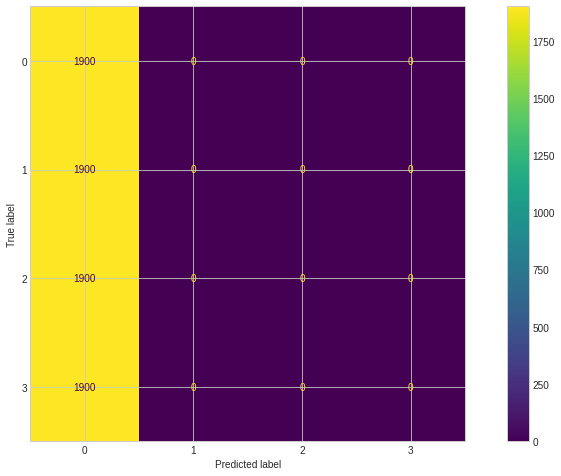

In [ ]:
# --------------------- (1) Baseline: Dummy Classifier ---------------------

# Train the dummy classifier who always predicts the 'most frequent' class
baseline = DummyClassifier(strategy='most_frequent')
dummy_start_time = time.time()
baseline.fit(x_train_tfidf, train_y)
dummy_end_time = time.time()


# Plot the confussion matrix for the test data
print("\nConfusion Matrix for test data:")
plot_confusion_matrix(estimator=baseline, X=x_test_tfidf, y_true = test_y, values_format = '.0f')

Train micro f1-score: 92.07%
Train macro f1-score: 92.06% 

Val micro f1-score: 90.20%
Val macro f1-score: 90.13% 

Test micro f1-score: 90.20%
Test macro f1-score: 90.17% 


Confusion Matrix for dev data:


,Precision,Recall,F1-score,P-R-AUC,Number of instances
World,90.62%,90.46%,90.54%,96.24%,9682
Sports,95.03%,97.06%,96.03%,98.78%,10491
Business,89.50%,83.76%,86.54%,93.90%,10439
Sci/Tech,85.48%,89.45%,87.42%,93.30%,9908
Accuracy,-,-,-,-,0
Macro averaged,90.15%,90.18%,90.13%,-,40520
Weighted averaged,90.21%,90.20%,90.17%,-,40520


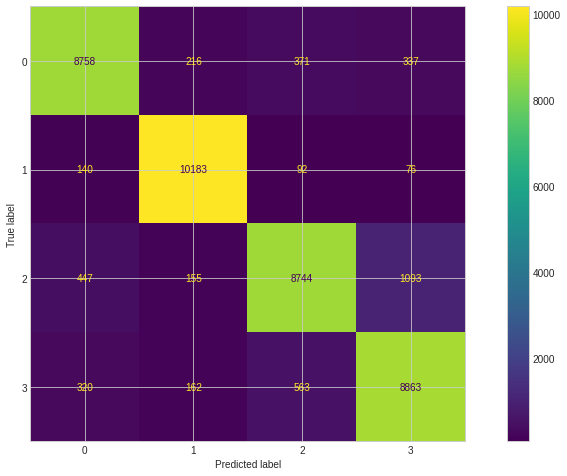

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc, roc_auc_score
# --------------------- (2) Logistic Regression ---------------------

# Train
clf = LogisticRegression(solver="liblinear")
start_time_lr = time.time()
clf.fit(x_train_tfidf, train_y)
end_time_lr = time.time()

#Evaluate
predictions = clf.predict(x_train_tfidf)

micro_f1_score_train = f1_score(train_y, predictions, average='micro')
macro_f1_score_train = f1_score(train_y, predictions, average='macro')
print("Train micro f1-score: {:.2f}%".format(micro_f1_score_train*100))
print("Train macro f1-score: {:.2f}% \n".format(macro_f1_score_train*100))


predictions_dev = clf.predict(x_val_tfidf)
micro_f1_score_dev = f1_score(dev_y, predictions_dev, average='micro')
macro_f1_score_dev = f1_score(dev_y, predictions_dev, average='macro')
print("Val micro f1-score: {:.2f}%".format(micro_f1_score_dev*100))
print("Val macro f1-score: {:.2f}% \n".format(macro_f1_score_dev*100))

predictions_test = clf.predict(x_test_tfidf)
micro_f1_score_test = f1_score(test_y, predictions_test, average='micro')
macro_f1_score_test = f1_score(test_y, predictions_test, average='macro')
print("Test micro f1-score: {:.2f}%".format(micro_f1_score_test*100))
print("Test macro f1-score: {:.2f}% \n".format(macro_f1_score_test*100))

# Plot the confussion matrix for the dev data
print("\nConfusion Matrix for dev data:")
plot_confusion_matrix(estimator=clf, X=x_val_tfidf, y_true=dev_y, values_format = '.0f')
report_lr_dev = classification_report(dev_y, predictions_dev, target_names=target_list, output_dict=True)

pred = clf.predict_proba(x_val_tfidf)
# For each class
precision = dict()
recall = dict()
average_precision = dict()
area = dict()
for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve(y_val_1_hot[:, i], pred[:, i])
    average_precision[i] = average_precision_score(y_val_1_hot[:, i], pred[:, i])
    # A "micro-average": quantifying score on each class
    category = "micro-" + target_list[i]
    precision[category], recall[category], _ = precision_recall_curve(
    y_val_1_hot[:, i], pred[:, i])
    area[category] = auc(recall[category], precision[category])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_val_1_hot.ravel(), pred.ravel()
)
area_all = auc(recall['micro'], precision['micro'])
# Display the results: Train
edit_dataframe(pd.DataFrame(report_lr_dev).transpose(), area, 'dev')

**Custom Keras callback for calculating f1, precision, recall at the end of each epoch**

In [ ]:
# --- Customly defined metrics class. ---

class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        val_targ = tf.cast(val_targ,dtype=tf.float32)
        
        _val_f1 = f1_score(val_targ, val_predict,average="weighted")
        _val_recall = recall_score(val_targ, val_predict,average="weighted")
        _val_precision = precision_score(val_targ, val_predict,average="weighted")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

**MLP classifier in Keras using tf*idf features**

In [ ]:
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

with tf.device('/device:GPU:0'):

  model = Sequential()
  model.add(Dense(1024, input_dim=x_train_svd.shape[1], activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(256,  activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(len(target_list),  activation='softmax'))

  print(model.summary())

  #Configures the model for training.
  #CategoricalCrossentropy: Computes the crossentropy loss between the labels and predictions.

  model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=0.01),
    metrics=["accuracy"]
    )

  if not os.path.exists('./checkpoints'):
      os.makedirs('./checkpoints')

  # Callback to save the Keras model or model weights at some frequency.  
  checkpoint = ModelCheckpoint(
    'checkpoints/weights.hdf5',
    monitor='val_accuracy', 
    mode='max', 
    verbose=2,
    save_best_only=True,
    save_weights_only=True
    )

  early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    min_delta=0.001
  )

  start_training_time = time.time()
  history = model.fit(
    x_train_svd, 
    y_train_1_hot,
    validation_data=(x_dev_svd, y_val_1_hot),
    batch_size=256,
    epochs=50,
    shuffle=True,
    callbacks=[Metrics(valid_data=(x_dev_svd, y_val_1_hot)), checkpoint]
    )
  end_training_time = time.time()

  print(f'\nTraining time: {time.strftime("%H:%M:%S", time.gmtime(end_training_time - start_training_time))} sec\n')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 1024)              513024    
                                                                 
 batch_normalization_21 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_29 (Dense)            (None, 512)               524800    
                                                                 
 batch_normalization_22 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 512)              

None
Epoch 1/50
1267/1267 [==============================] - 3s 2ms/step
 — val_f1: 0.861861 — val_precision: 0.867552 — val_recall: 0.860661

Epoch 1: val_accuracy improved from -inf to 0.86066, saving model to checkpoints/weights.hdf5
300/300 [==============================] - 11s 27ms/step - loss: 0.5693 - accuracy: 0.8117 - val_loss: 0.7676 - val_accuracy: 0.8607 - val_f1: 0.8619 - val_recall: 0.8607 - val_precision: 0.8676
Epoch 2/50
1267/1267 [==============================] - 4s 3ms/step
 — val_f1: 0.888261 — val_precision: 0.889465 — val_recall: 0.888302

Epoch 2: val_accuracy improved from 0.86066 to 0.88830, saving model to checkpoints/weights.hdf5
300/300 [==============================] - 8s 27ms/step - loss: 0.3500 - accuracy: 0.8807 - val_loss: 0.3214 - val_accuracy: 0.8883 - val_f1: 0.8883 - val_recall: 0.8883 - val_precision: 0.8895
Epoch 3/50
1267/1267 [==============================] - 3s 2ms/step
 — val_f1: 0.891053 — val_precision: 0.892074 — val_recall: 0.891486

E

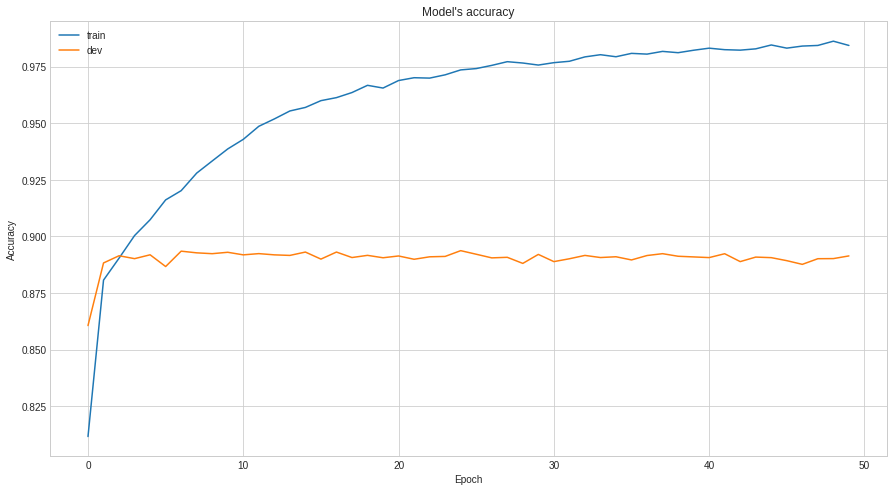

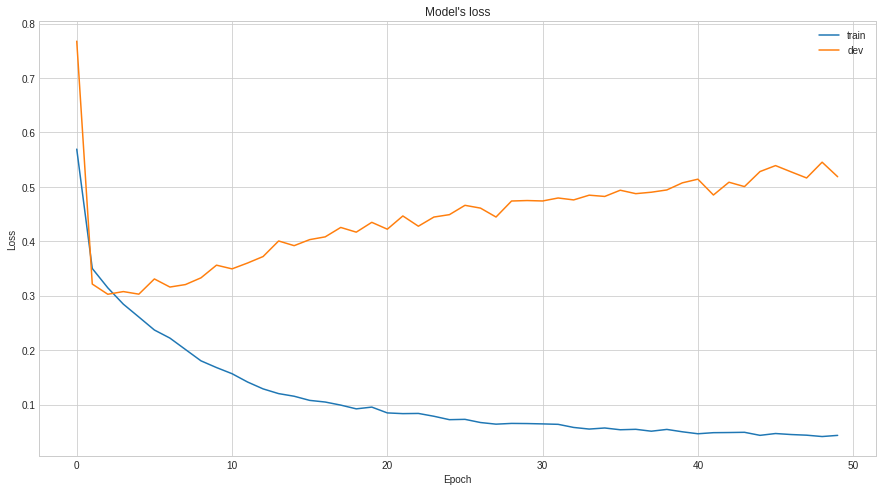

In [ ]:
# summarize history for accuracy
plt.rcParams["figure.figsize"] = (15,8)
# plt.rcParams['axes.facecolor'] = 'white'
plt.style.use('seaborn-whitegrid')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model's accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show();

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show();

# ***Evaluate performance of tf-idf MLP model***

In [ ]:
import warnings
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

target_list = ["World", "Sports", "Business", "Sci/Tech"]

with tf.device('/device:GPU:0'):

  model = Sequential()
  model.add(Dense(1024, input_dim=x_dev_svd.shape[1] , activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(256,  activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(len(target_list),  activation='softmax'))
  
  # Load weights from the pre-trained model
  model.load_weights("checkpoints/weights.hdf5")
  model.compile(
      loss='categorical_crossentropy',
      optimizer=Adam(lr=0.01),
      metrics=["accuracy"]
      )

  predictions = np.argmax(model.predict(x_dev_svd), -1)
  report_mlp_dev = classification_report(dev_y, predictions, target_names=target_list)
  print(report_mlp_dev)

  pred = model.predict(x_dev_svd)
  # For each class
  precision = dict()
  recall = dict()
  average_precision = dict()
  area = dict()
  for i in range(4):
      precision[i], recall[i], _ = precision_recall_curve(y_val_1_hot[:, i], pred[:, i])
      average_precision[i] = average_precision_score(y_val_1_hot[:, i], pred[:, i])
      # A "micro-average": quantifying score on each class
      category = "micro-" + target_list[i]
      precision[category], recall[category], _ = precision_recall_curve(
      y_val_1_hot[:, i], pred[:, i])
      area[category] = auc(recall[category], precision[category])

  # A "micro-average": quantifying score on all classes jointly
  precision["micro"], recall["micro"], _ = precision_recall_curve(
      y_val_1_hot.ravel(), pred.ravel()
  )
  area_all = auc(recall['micro'], precision['micro'])
  # Display the results: Train
  #edit_dataframe(pd.DataFrame(report_mlp_dev).transpose(), area, 'dev')
    

1267/1267 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

       World       0.92      0.88      0.90      9682
      Sports       0.94      0.96      0.95     10491
    Business       0.88      0.83      0.86     10439
    Sci/Tech       0.83      0.89      0.86      9908

    accuracy                           0.89     40520
   macro avg       0.89      0.89      0.89     40520
weighted avg       0.89      0.89      0.89     40520

1267/1267 [==============================] - 3s 2ms/step


# ***Fine Tuning using Keras Tuner***

In [ ]:
def model_builder(hp):
  model = tf.keras.Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512

  activation_ = hp.Choice("activation", ["relu", "tanh"])
  for i in range(hp.Int('num_layers', 2, 5)):
    if i==0:
      hp_units0 = hp.Int('units_layer_'+str(i), min_value=512, max_value=1024, step=128)
      print('units_layer_'+str(i) + ': ' + str(hp_units0) + ' neurons.')
      model.add(tf.keras.layers.Dense(units=hp_units0, input_dim=x_train_svd.shape[1], activation = activation_)) # input_dim=x_train_svd.shape[1],
    elif i==1:
      hp_units1 = hp.Int('units_layer_'+str(i), min_value=256, max_value=512, step=64)
      print('units_layer_'+str(i) + ': ' + str(hp_units1) + ' neurons.')
      model.add(tf.keras.layers.Dense(units=hp_units1, activation = activation_))
    else:
      hp_units2 = hp.Int('units_layer_'+str(i), min_value=64, max_value=256, step=64)
      print('units_layer_'+str(i) + ': ' + str(hp_units2) + ' neurons.')
      model.add(tf.keras.layers.Dense(units=hp_units1, activation = activation_))

    hp_dropout = hp.Float('dropout_rate', min_value=0.3, max_value=0.6,step=0.05)
    model.add(BatchNormalization())
    model.add(Dropout(hp_dropout))

  model.add(Dense(len(target_list),  activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  #hp_optimizer = hp.Choice('optimizer', ['Adam', 'sgd'])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy', 'categorical_crossentropy'])

  return model

In [ ]:
!pip3 install -q -U keras-tuner

     |████████████████████████████████| 135 kB 31.1 MB/s 
     |████████████████████████████████| 1.6 MB 49.7 MB/s 


In [ ]:
import keras_tuner as kt

In [ ]:
tuner_t2 = kt.RandomSearch(model_builder,
                     objective=kt.Objective("val_categorical_crossentropy", direction="min"),
                     max_trials=30,
                     directory="nlp3",
                     project_name="finetuning9")

units_layer_0: 512 neurons.
units_layer_1: 256 neurons.


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_crossentropy', patience=3)

In [ ]:
tuner_t2.search(x_train_svd, y_train_1_hot, epochs=15, callbacks=[stop_early], validation_data=(x_dev_svd, y_val_1_hot))

Trial 30 Complete [00h 01m 35s]
val_categorical_crossentropy: 0.43931663036346436

Best val_categorical_crossentropy So Far: 0.2958736717700958
Total elapsed time: 01h 48m 17s


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner_t2.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
print(f"""
The hyperparameter search is complete. The optimal number of layers is {best_hps.get('num_layers')}. The optimal number of units in the first densely-connected
layer is {best_hps.get('units_layer_0')} , the optimal activation function is {best_hps.get('activation')}, the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}. The optimal dropout rate is {best_hps.get('dropout_rate')}.
""")


The hyperparameter search is complete. The optimal number of layers is 3. The optimal number of units in the first densely-connected
layer is 896 , the optimal activation function is relu, the optimal learning rate for the optimizer
is 0.0001. The optimal dropout rate is 0.39999999999999997.



In [ ]:
model_ft = tuner_t2.hypermodel.build(best_hps)

units_layer_0: 896 neurons.
units_layer_1: 256 neurons.
units_layer_2: 64 neurons.


In [ ]:
print(model_ft.summary())
print(model_ft.layers[0].activation)

history = model_ft.fit(
    x_train_svd, 
    y_train_1_hot,
    validation_data=(x_dev_svd, y_val_1_hot),
    batch_size=256,
    epochs=50,
    shuffle=True,
    callbacks=[Metrics(valid_data=(x_dev_svd, y_val_1_hot)), checkpoint]
    )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 896)               448896    
                                                                 
 batch_normalization_4 (Batc  (None, 896)              3584      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 896)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               229632    
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 256)              

In [ ]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 26


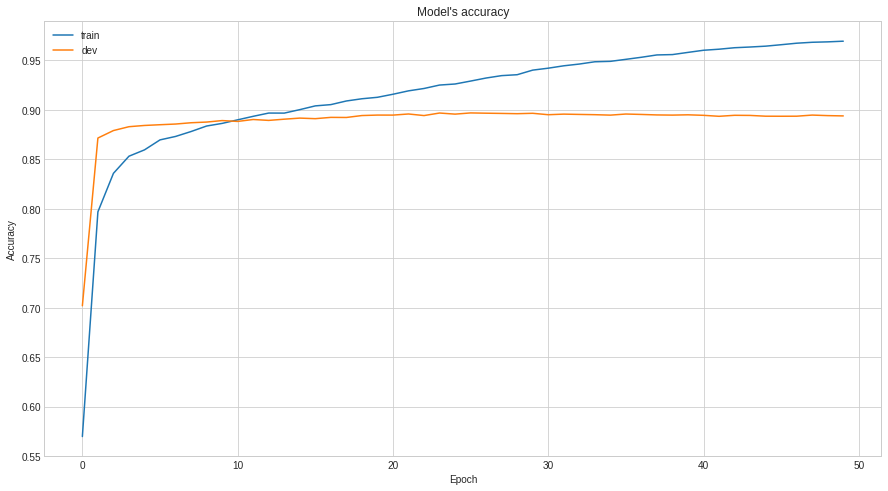

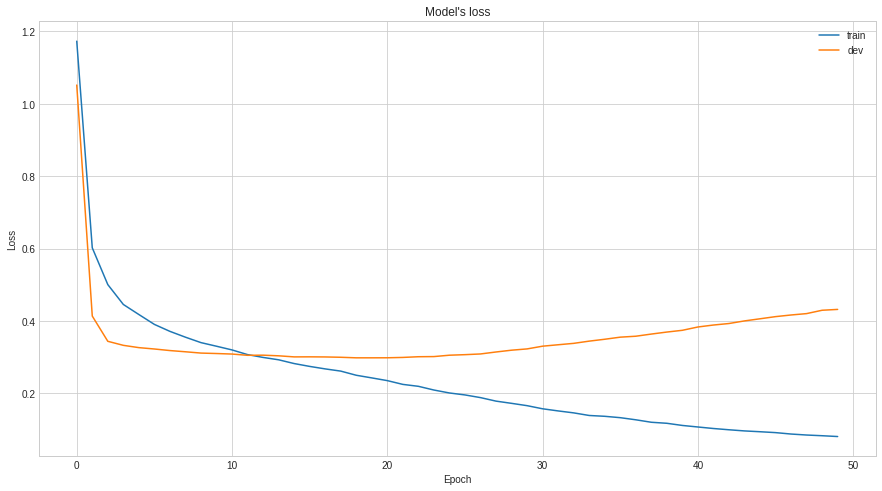

In [ ]:
# summarize history for accuracy
plt.rcParams["figure.figsize"] = (15,8)
# plt.rcParams['axes.facecolor'] = 'white'
plt.style.use('seaborn-whitegrid')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model's accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show();

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show();

In [ ]:
hypermodel = tuner_t2.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(x_train_svd, 
    y_train_1_hot,
    validation_data=(x_dev_svd, y_val_1_hot),
    batch_size=256,
    epochs=best_epoch,
    shuffle=True,
    callbacks=[Metrics(valid_data=(x_dev_svd, y_val_1_hot)), checkpoint])

units_layer_0: 896 neurons.
units_layer_1: 256 neurons.
units_layer_2: 64 neurons.
Epoch 1/26
1267/1267 [==============================] - 3s 2ms/step
 — val_f1: 0.583382 — val_precision: 0.796282 — val_recall: 0.574235

Epoch 1: val_accuracy did not improve from 0.89692
300/300 [==============================] - 11s 27ms/step - loss: 1.1664 - accuracy: 0.5729 - categorical_crossentropy: 1.1664 - val_loss: 1.0694 - val_accuracy: 0.5742 - val_categorical_crossentropy: 1.0694 - val_f1: 0.5834 - val_recall: 0.5742 - val_precision: 0.7963
Epoch 2/26
1267/1267 [==============================] - 3s 2ms/step
 — val_f1: 0.866731 — val_precision: 0.868497 — val_recall: 0.866856

Epoch 2: val_accuracy did not improve from 0.89692
300/300 [==============================] - 8s 26ms/step - loss: 0.6039 - accuracy: 0.7974 - categorical_crossentropy: 0.6039 - val_loss: 0.4220 - val_accuracy: 0.8669 - val_categorical_crossentropy: 0.4220 - val_f1: 0.8667 - val_recall: 0.8669 - val_precision: 0.8685
Ep

In [ ]:
eval_result = hypermodel.evaluate(x_test_svd, y_test_1_hot)
print("[test loss, test accuracy]:", eval_result)

238/238 [==============================] - 1s 3ms/step - loss: 0.3065 - accuracy: 0.8992 - categorical_crossentropy: 0.3065
[test loss, test accuracy]: [0.30645185708999634, 0.899210512638092, 0.30645185708999634]
